<a href="https://colab.research.google.com/github/realmiketalbot/CIVE580C3/blob/main/assignments/homework3/homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: Water Balance
In this homework, you will evaluate multiple fluxes and their effect on soil water storage in several pre-defined regions, as well as in the study area of your term projeoct. You will download precipitation, ETo, and soil moisture over each region as a time series, then evaluate drivers of soil moisture.

Next, you will repeat the exercise over the watershed you have chosen for your term project.

As you go through the assignment, follow prompts to fill out a lab report in a word document. You will turn in the word document along with the code you used.

First we need to install a couple packages. If this shows an error after running, try the next code block. If it runs without an error, then you should be ok.

In [13]:
pip install geemap pycrs contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 47.3 MB/s eta 0:00:00


Now we will clone the git repository, which gives us easy access to the shapefiles you will need

In [3]:
!git clone https://github.com/realmiketalbot/CIVE580C3.git

Cloning into 'CIVE580C3'...
remote: Enumerating objects: 845, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 845 (delta 95), reused 41 (delta 22), pack-reused 635 (from 1)
Receiving objects: 100% (845/845), 119.55 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (393/393), done.
Updating files: 100% (702/702), done.


In [14]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import requests
from tqdm import tqdm
import zipfile
import os
import pandas as pd
from glob import glob
import geemap
import folium
import branca.colormap as cm

In [15]:
# you only need to run this once per session
ee.Authenticate()
ee.Initialize(project='ee-cive580c3-lecture3')

# Define custom functions

In [16]:
def add_ee_layer(self, ee_object, name):
    try:
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):
            range = ee.Image(ee_object).reduceRegion(ee.Reducer.percentile([1, 99]),scale=10000)
            vals = range.getInfo()
            min=list(vals.items())[0][1]
            max=list(vals.items())[1][1]
            vis = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}

            map_id_dict = ee.Image(ee_object).getMapId(vis)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
            colormap = cm.LinearColormap(vmin=min,vmax=max,colors=['blue', 'white','red']).to_step(n=10)
            colormap.caption=name
            self.add_child(colormap)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)

    except Exception as e:
        print("Could not display {}".format(name))
        print(e)

# Add EE drawing method to folium (not a function)
folium.Map.add_ee_layer = add_ee_layer

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

def gee_zonal_mean_img_coll(imageCollection,geometry,scale=1000):
    reduce_iC = create_reduce_region_function(geometry = geometry, scale=scale)
    stat_fc = ee.FeatureCollection(imageCollection.map(reduce_iC)).filter(ee.Filter.notNull(imageCollection.first().bandNames()))
    fc_dict = fc_to_dict(stat_fc).getInfo()

    df = pd.DataFrame(fc_dict)
    df['date'] = pd.to_datetime(df['millis'],unit='ms')
    return(df)

def gee_zonal_mean(date1,date2,geometry,collection_name,band_name,scale=1000):
     imcol = ee.ImageCollection(collection_name).select(band_name).filterDate(date1,date2)
     df = gee_zonal_mean_img_coll(imcol,geometry,scale=scale)
     return(df)


# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

def ee_imgcoll_to_df_point(imagecollection, lat,lon):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    poi = ee.Geometry.Point(lon, lat)
    arr = imagecollection.getRegion(poi,1000).getInfo()

    list_of_bands = imagecollection.first().bandNames().getInfo()

    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

# to get the link to download an earth engine image
def getLink(image,fname,aoi):
  link = image.getDownloadURL({
    'scale': 1000,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': aoi,
    'name': fname})
  # print(link)
  return(link)

# create an earth engine geometry polygon
def addGeometry(min_lon,max_lon,min_lat,max_lat):
  geom = ee.Geometry.Polygon(
      [[[min_lon, max_lat],
        [min_lon, min_lat],
        [max_lon, min_lat],
        [max_lon, max_lat]]])
  return(geom)

def get_imgcollection(date1,date2,geometry,collection_name,band_name,function='mean'):
  collection = ee.ImageCollection(collection_name)
  if function=='mean':
      img = collection.filterDate(date1,date2).select(band_name).mean().clip(geometry)
  if function=='sum':
      img = collection.filterDate(date1,date2).select(band_name).sum().clip(geometry)
 # range = img.reduceRegion(ee.Reducer.percentile([1, 99]),scale=10000)
 # vals = range.getInfo()
 # min=list(vals.items())[0][1]
 # max=list(vals.items())[1][1]
 # visParams = {'min': min, 'max': max, 'palette': ['0000FF', 'FFFFFF','FF0000']}
  return(img)

def download_img(img,geom,fname):
    linkname = getLink(img,fname,geom)
    response = requests.get(linkname, stream=True)
    zipped = fname+'.zip'
    with open(zipped, "wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)

    with zipfile.ZipFile(zipped, 'r') as zip_ref:
        zip_ref.extractall('')
    os.remove(zipped)


def aggregate_by_water_year(df,date_col,agg_column,agg_fun='sum'):
    df['water_year'] = df[date_col].dt.year.where(df[date_col].dt.month < 10, df[date_col].dt.year + 1)
    df_agg = df.groupby('water_year').agg({agg_column:[agg_fun]})
    return(df_agg)

# Part 1: Gather and plot water balance data over pre-defined regions

In [17]:
start='2020-04-01'
end='2020-09-30'
from glob import glob
paths = glob('/content/CIVE580C3/data/hw3/*.shp')

In [18]:
# upload watershed to GEE----------------------------
gee_wsheds = []
for kk in range(len(paths)):
  gee_wsheds.append(geemap.shp_to_ee(paths[kk]))

We have a list of path names for all shapefiles that will be analyzed in part 1. The code below will plot where they are on an interactive map. You can use the layer control on the top right to toggle basemaps, and check/un-check layers to see what name is associated with each shapefile.

<ipython-input-19-9be1647b740f>:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
<ipython-input-19-9be1647b740f>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


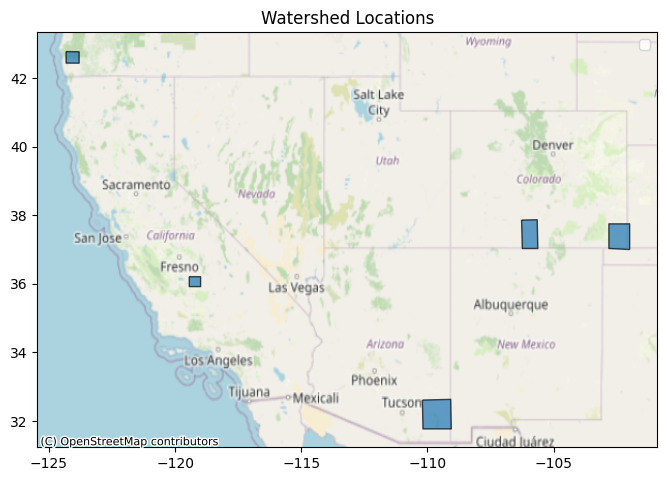

In [19]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Loop through shapefiles and plot each one
for path in paths:
    shp = gpd.read_file(path)
    shpname = path.split('/')[-1].split('.')[0]
    shp.plot(ax=ax, label=shpname, edgecolor='black', alpha=0.7)

# Add an OSM basemap
ctx.add_basemap(ax, crs=shp.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Add labels and legend
ax.set_title("Watershed Locations")
ax.legend()

# Save the figure as map1.png
plt.savefig("map1.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

In [20]:
# take the spatial mean to get area-averaged time series over each shapefile. This will take a few minutes

for kk, watershed_gee in enumerate(gee_wsheds):
  print(kk)

  fname_stem = paths[kk].split('/')[-1].split('.')[0]

  gridmet_ppt = gee_zonal_mean(start,end,watershed_gee.geometry(),'IDAHO_EPSCOR/GRIDMET','pr',scale=10000)
  gridmet_ppt = gridmet_ppt[['pr','date']].set_index('date')
  gridmet_ppt.index = gridmet_ppt.index.to_period('D')

  gridmet_eto = gee_zonal_mean(start,end,watershed_gee.geometry(),'IDAHO_EPSCOR/GRIDMET','eto',scale=10000)
  gridmet_eto = gridmet_eto[['eto','date']].set_index('date')
  gridmet_eto.index = gridmet_eto.index.to_period('D')

  soil_moisture_df = gee_zonal_mean(start,end,watershed_gee.geometry(),'NASA/SMAP/SPL3SMP_E/006','soil_moisture_am',scale=10000)
  soil_moisture_df = soil_moisture_df[['soil_moisture_am','date']].set_index('date')
  soil_moisture_df.index = soil_moisture_df.index.to_period('D')

  # join dataframes

  merged_df = gridmet_ppt[['pr']].join(gridmet_eto[['eto']]).join(soil_moisture_df[['soil_moisture_am']])

  merged_df.to_csv(fname_stem+'_merged_data.csv')

0
1
2
3
4


In [ ]:
from glob import glob
csv_files = glob('*.csv')
print(csv_files)

Now, create plots similar to the plot below for each of the time series generated. You can do this in python, Excel, or any other tool of your choosing, but the plots should clearly show precipitation, ETo, and soil moisture with a consistent x-axis, so that it is easy to determine the effect of each on soil moisture. Include the plots in a word document that you will turn in with the project, along with your code.

After generating the plots, comment on similarities and differences among the regions. In your evaluation, include interpretation of the response of soil moisture to different drivers (precip, ETo as well as other potential drivers).

In addition to qualitative interpretations, provide some quantitative evaluation of either soil moisture trends or soil moisture response to external drivers for each region (this is intentionally vague--you may choose what and how to quantify).

Note that this portion of the exercise can also be done in python, Excel or with any other tool, so long as it is your own work. In your report, describe what tool you used, and turn in any code you used.

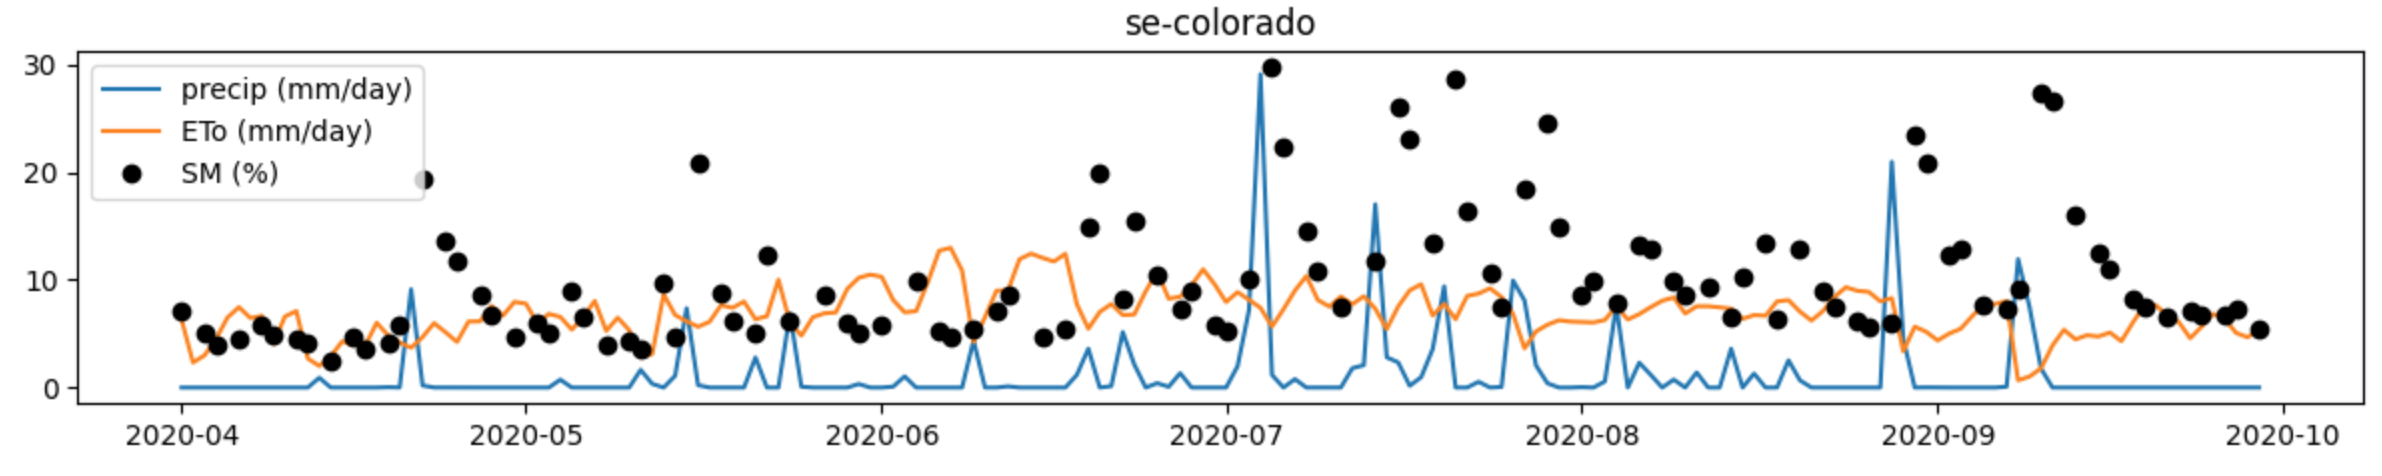

Choose one of the regions to make a map. Using the same method as lab 1, make a folium map of that region, along with average soil moisture, precipitation and ETo over the region. Take a screenshot of the map and include in your word document.

In [ ]:
# placeholder for map

# Part 2: repeat this analysis over your own study area
First, upload a shapefile of your study area or a portion of your study area to the files directory. Be sure to include ALL FILES WITH THE SAME STEM (.shp, .dbf, .prj, .shx, etc). Make a note of the path to your shapefile. If you put it in the main directory it should just be 'filename.shp' or whatever you named it.

Then, repeat the analysis performed in part 1 over your study area. In most cases, you can just copy and paste code from the appropriate section.

In [ ]:
start='yyyy-mm-dd'
end='yyyy-mm-dd'
shapefile='<path to shapefile>.shp'

In [ ]:
# upload watershed to GEE----------------------------
shapefile = geemap.shp_to_ee(path_to_watershed)